# YOLIC - You Only Look at Interested Cells

## 1. Common YOLIC code

#### 1.1 Imports and constants

In [2]:
from typing import Any
from os import listdir
from pathlib import Path 
import json

from PIL import Image

import torch
import torch.nn as nn

import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from torch.utils.data import Dataset, DataLoader

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision import transforms

from torcheval.metrics import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall

from alive_progress import alive_bar

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [3]:
NUMBER_OF_COIS = 8
NUMBER_OF_CLASSES = 1

YOLIC_NET_INPUT_WIDTH = 224
YOLIC_NET_INPUT_HEIGHT = 224

TRAIN_IMAGE_DIR = Path("./CarLast/training/images/")
VAL_IMAGE_DIR = Path("./CarLast/validation/images/")
# TEST_IMAGE_DIR = Path("../CarLast/test/images/")

TRAIN_LABEL_DIR = Path("./CarLast/training/yolic_labels/")
VAL_LABEL_DIR = Path("./CarLast/validation/yolic_labels/")


CSV_FILE = Path("training_data.csv")

YOLIC_MODEL_PATH = Path("yolic_model.pt")

#### 1.2 Dataset class

In [4]:
class YolicDataset(Dataset):
    """Yolic Dataset class used to load images and label"""

    def __init__(
        self,
        image_dir: Path,
        label_dir: Path,
        transform=None,
    ):
        """Initialize YolicDataset class"""
        self._image_dir = image_dir
        self._label_dir = label_dir
        self._image_names = listdir(image_dir)
        self._transform = transform

    def __len__(self) -> int:
        """Return the length of the dataset"""
        return len(self._image_names)

    def __getitem__(self, index) -> tuple[Any, torch.Tensor, str]:
        """Return image, label and image name"""

        image_name = Path(self._image_names[index])

        image_path = self._image_dir / image_name
        label_path = self._label_dir / image_name.with_suffix(".txt")

        label = torch.from_numpy(np.loadtxt(fname=label_path, dtype=np.float32))

        image = Image.open(image_path).convert("RGB")

        if self._transform is not None:
            image = self._transform(image)
        # add random augmentation here
        filename = image_name.stem
        return image, label, filename

#### 1.3 Model function

In [5]:
def yolic_net(weights=None) -> nn.Module:
    """Returns a Yolic model"""

    model = mobilenet_v2(weights=weights)
    model.classifier = nn.Sequential(  # Swap out the classifier
        nn.Dropout(p=0.2),
        nn.Linear(
            in_features=model.last_channel,
            out_features=(NUMBER_OF_COIS * (NUMBER_OF_CLASSES + 1)),
        ),
    )
    return model

## 2. Train YOLIC

#### 2.1 Train and validation step

In [6]:
def train_step(
    model: nn.Module,
    loss_fn: Any,
    accuracy_fn: Any,
    f1_score_fn: Any,
    precision_fn: Any,
    recall_fn: Any,
    optimizer: optim.Optimizer,
    device: torch.device,
    data_loader: DataLoader,
) -> tuple[float, float]:
    """Perform a single training step"""

    train_loss = 0.0
    model.train()
    with alive_bar(len(data_loader)) as bar:
        for images, labels, _ in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass
            output = model(images)
            loss = loss_fn(output, labels)
            train_loss += loss.item()

            output = torch.sigmoid(output)

            # calculate metrics
            labels = labels.to(torch.int64)
            for i in range(len(output)):
                accuracy_fn.update(output[i], labels[i])
                f1_score_fn.update(output[i], labels[i])
                precision_fn.update(output[i], labels[i])
                recall_fn.update(output[i], labels[i])

            # backward pass
            loss.backward()
            optimizer.step()

            # update the progress bar
            bar()

    train_loss = train_loss / len(data_loader)
    train_accuracy = accuracy_fn.compute().item()
    train_f1_score = f1_score_fn.compute().item()
    train_precision = precision_fn.compute().item()
    train_recall = recall_fn.compute().item()

    accuracy_fn.reset()
    f1_score_fn.reset()
    precision_fn.reset()
    recall_fn.reset()

    return train_loss, train_accuracy, train_f1_score, train_precision, train_recall

In [7]:
def validation_step(
    model: nn.Module,
    loss_fn: Any,
    accuracy_fn: Any,
    f1_score_fn: Any,
    precision_fn: Any,
    recall_fn: Any,
    device: torch.device,
    data_loader: DataLoader,
) -> tuple[float, float]:
    """Perform validation of a model"""

    validation_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            loss = loss_fn(output, labels)
            validation_loss += loss.item()

            output = torch.sigmoid(output)

            # calculate metrics
            labels = labels.to(torch.int64)
            for i in range(len(output)):
                accuracy_fn.update(output[i], labels[i])
                f1_score_fn.update(output[i], labels[i])
                precision_fn.update(output[i], labels[i])
                recall_fn.update(output[i], labels[i])


    validation_loss = validation_loss / len(data_loader)
    validation_accuracy = accuracy_fn.compute().item()
    validation_f1_score = f1_score_fn.compute().item()
    validation_precision = precision_fn.compute().item()
    validation_recall = recall_fn.compute().item()

    accuracy_fn.reset()
    
    return (
        validation_loss,
        validation_accuracy,
        validation_f1_score,
        validation_precision,
        validation_recall,
    )

#### 2.2 Hyperparameters

In [8]:
EPOCHS = 40
BATCH_SIZE = 40
LEARNING_RATE = 0.001

#### 2.3 YOLIC train function

In [9]:
def yolic_train():
    """Main function"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")

    # Declare model, loss function, optimizer and scheduler
    model = yolic_net(weights=MobileNet_V2_Weights.DEFAULT)
    model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = MultiStepLR(optimizer, milestones=[20, 25], gamma=0.1)

    # Declare transforms
    train_transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    )
    validation_transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    )

    # Create datasets
    train_dataset = YolicDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, train_transform)
    validation_dataset = YolicDataset(VAL_IMAGE_DIR, VAL_LABEL_DIR, validation_transform)
    print(f"Train data: {len(train_dataset)}")
    print(f"Validation data: {len(validation_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
    )
    validation_loader = DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
    )

    # Train model
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    train_precision = []
    train_recall = []

    validation_loss = []
    validation_accuracy = []
    validation_f1_score = []
    validation_precision = []
    validation_recall = []

    smallest_validation_loss = float("inf")
    for epoch in range(EPOCHS):
        print(f"\nEpoch: {epoch+1} / {EPOCHS}")
        (
            epoch_train_loss,
            epoch_train_accuracy,
            epoch_train_f1_score,
            epoch_train_precision,
            epoch_train_recall,
        ) = train_step(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=BinaryAccuracy(),
            f1_score_fn=BinaryF1Score(),
            precision_fn=BinaryPrecision(),
            recall_fn=BinaryRecall(),
            optimizer=optimizer,
            device=device,
            data_loader=train_loader,
        )

        (
            epoch_validation_loss,
            epoch_validation_accuracy,
            epoch_validation_f1_score,
            epoch_validation_precision,
            epoch_validation_recall,
        ) = validation_step(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=BinaryAccuracy(),
            f1_score_fn=BinaryF1Score(),
            precision_fn=BinaryPrecision(),
            recall_fn=BinaryRecall(),
            device=device,
            data_loader=validation_loader,
        )
        scheduler.step()

        print(
            f"Train loss: {epoch_train_loss},",
            f"Train accuracy: {epoch_train_accuracy}",
            f"Train f1 score: {epoch_train_f1_score}",
            f"Train precision: {epoch_train_precision}",
            f"Train recall: {epoch_train_recall}",
        )
        print(
            f"Validation loss: {epoch_validation_loss},",
            f"Validation accuracy: {epoch_validation_accuracy}",
            f"Validation f1 score: {epoch_validation_f1_score}",
            f"Validation precision: {epoch_validation_precision}",
            f"Validation recall: {epoch_validation_recall}",
        )

        # TODO: Change metric to precision, recall or f1 score
        if epoch_validation_loss < smallest_validation_loss:
            smallest_validation_loss = epoch_validation_loss
            torch.save(model.state_dict(), YOLIC_MODEL_PATH)
            print(f"Saved new weights as {YOLIC_MODEL_PATH}")

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        train_f1_score.append(epoch_train_f1_score)
        train_precision.append(epoch_train_precision)
        train_recall.append(epoch_train_recall)


        validation_loss.append(epoch_validation_loss)
        validation_accuracy.append(epoch_validation_accuracy)
        validation_f1_score.append(epoch_validation_f1_score)
        validation_precision.append(epoch_validation_precision)
        validation_recall.append(epoch_validation_recall)

        pd.DataFrame(
            {
                "train_loss": train_loss,
                "validation_loss": validation_loss,
                "train_accuracy": train_accuracy,
                "validation_accuracy": validation_accuracy,
                "train_f1_score": train_f1_score,
                "validation_f1_score": validation_f1_score,
                "train_precision": train_precision,
                "validation_precision": validation_precision,
                "train_recall": train_recall,
                "validation_recall": validation_recall,
            }
        ).to_csv(CSV_FILE, index=False)
        print(f"Added new metrics to {CSV_FILE}")

#### 2.4 Start YOLIC training

In [9]:
yolic_train()

Using cuda


Train data: 1700
Validation data: 300

Epoch: 1 / 40
|████████████████████████████████████████| 43/43 [100%] in 1:04.6 (0.67/s) 
Train loss: 0.22917623055535694, Train accuracy: 0.8968750238418579 Train f1 score: 0.8969090580940247 Train precision: 0.8966125249862671 Train recall: 0.8972058892250061
Validation loss: 0.09550662245601416, Validation accuracy: 0.9622916579246521 Validation f1 score: 0.9622208476066589 Validation precision: 0.9640318155288696 Validation recall: 0.9604166746139526
Saved new weights as yolic_model.pt
Added new metrics to training_data.csv

Epoch: 2 / 40
|▉⚠︎                                      | (!) 1/43 [2%] in 3.3s (0.30/s) 


KeyboardInterrupt: 

#### 2.5 Plot training data

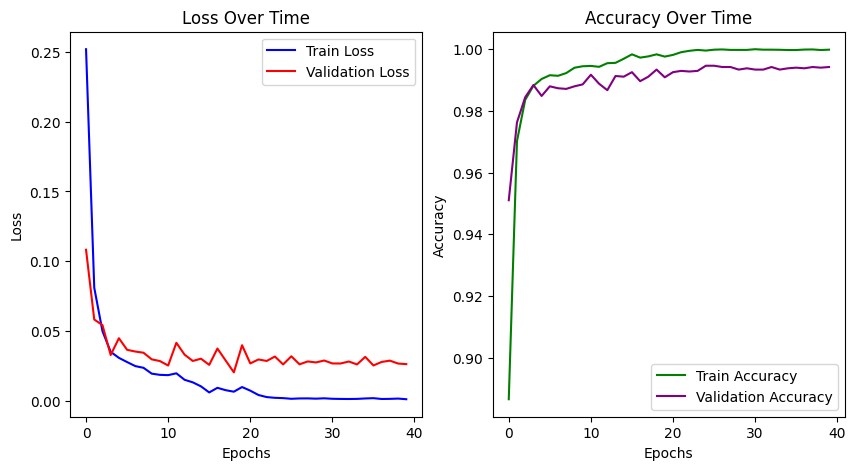

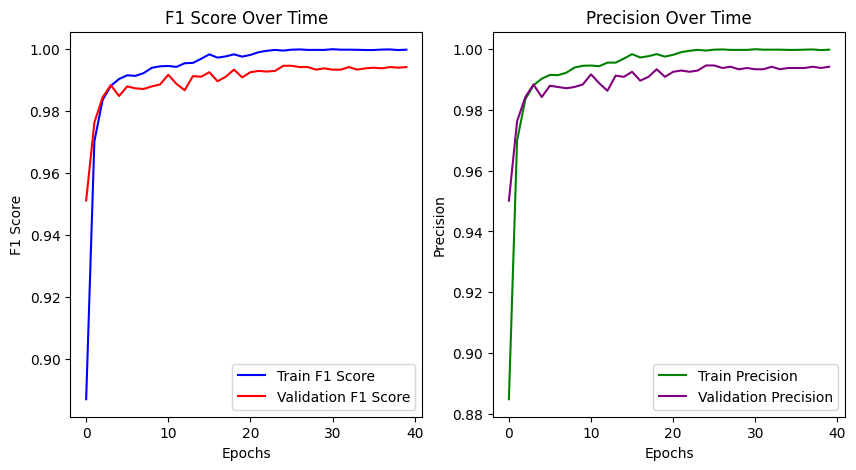

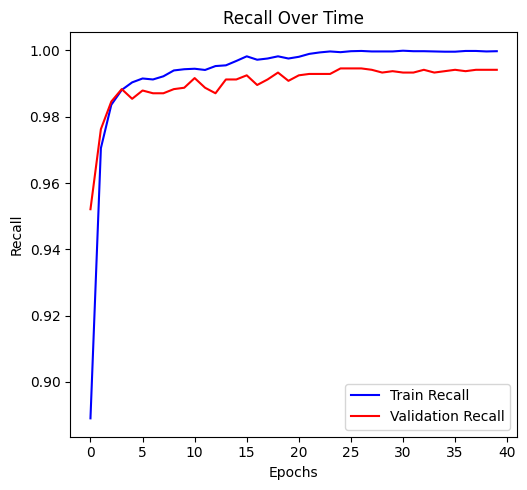

In [9]:
data = pd.read_csv(CSV_FILE)

# Extract the columns
train_loss = data['train_loss']
validation_loss = data['validation_loss']
train_accuracy = data['train_accuracy']
validation_accuracy = data['validation_accuracy']

# Create the first plot for loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create the second plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(validation_accuracy, label='Validation Accuracy', color='purple')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Create the third plot for f1 score
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(data['train_f1_score'], label='Train F1 Score', color='blue')
plt.plot(data['validation_f1_score'], label='Validation F1 Score', color='red')
plt.title('F1 Score Over Time')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Create the fourth plot for precision
plt.subplot(1, 2, 2)
plt.plot(data['train_precision'], label='Train Precision', color='green')
plt.plot(data['validation_precision'], label='Validation Precision', color='purple')
plt.title('Precision Over Time')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


# Create the fifth plot for recall
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(data['train_recall'], label='Train Recall', color='blue')
plt.plot(data['validation_recall'], label='Validation Recall', color='red')
plt.title('Recall Over Time')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()


# Adjust layout and show plots
plt.tight_layout()
plt.show()

## 3. Test YOLIC

In [10]:
CELLS_FILE = Path('./cell_design.json')
GENERATED_IMAGES_DIR = Path('./generated_images/')
COLOR_LABELS = {
    "Background": (255, 255, 255),
    "Vehicle": (255, 0, 0)
}


In [11]:
def to_matrix(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

In [12]:
def print_generated_image(image: torch.tensor, output: torch.tensor):
    image = np.array(image)
    output = to_matrix(output.tolist(), NUMBER_OF_CLASSES + 1)
    print(output)

    with open(str(CELLS_FILE)) as json_file:
        data = json.load(json_file)
        cois_data = data["COIs"]
        labels = data["Labels"]["LabelList"]

    labels.insert(0, "Background")

    # generate masks for every cell of interests
    for idx, coi in enumerate(cois_data, -1):
        if coi == "COINumber":
            continue
        # get label coi label
        label = labels[output[idx].index(1)]
        color = COLOR_LABELS[label]

        # reshape array of coordinates
        poly_cords = np.array(cois_data[coi][1:])
        num_cords = poly_cords.size // 2
        poly_cords = poly_cords.reshape(num_cords, 2)
        poly_cords = np.array(
            [
                np.multiply(cords, (YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH))
                for cords in poly_cords
            ]
        ).astype(np.int32)

        # get mask
        if cois_data[coi][0] == "polygon":
            cv2.polylines(image, [poly_cords], True, color, 2)
        else:
            [[x, y], [w, h]] = poly_cords
            cv2.rectangle(image, [x, y], [x + w, y + h], color, 2)

    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [52]:
# process file with cells of interests layout
def yolic_test():
    """Test the model on the test dataset and save the predicted images"""
    model = yolic_net()
    model.load_state_dict(torch.load(YOLIC_MODEL_PATH))
    transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    )
    dataset = YolicDataset(VAL_IMAGE_DIR, VAL_LABEL_DIR)
    model.eval()
    with torch.no_grad():
        for image, _, _ in dataset:
            transformed_image = transform(image)
            transformed_image = transformed_image.unsqueeze(0)
            output = model(transformed_image)
            output = torch.sigmoid(output)
            output = torch.where(output >= 0.5, torch.ones_like(output), torch.zeros_like(output)).to(torch.int64)
            print_generated_image(image, output[0])

In [ ]:
yolic_test()